In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [0]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# Paths for training & validation data. 
# You should create './PatternProject/Train or Validation' folders in your google drive
train_path = '/content/drive/My Drive/PatternProject/Train/' 
valid_path = '/content/drive/My Drive/PatternProject/Validation/'


In [0]:
#Prepare training data set
classes = ['Normal','Fracture']

data =[]
label =[]
resize = transforms.Compose([transforms.CenterCrop(400)]) #crop to 400

for i, d in enumerate(classes):
    files = os.listdir(train_path+d)
    
    for f in files:
        img = Image.open(train_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split() # same levels
        one_img = np.asarray(np.float32(r)/255.0) #choose one
        img = np.asarray([one_img])
        data.append(img)
        label.append(i)
        

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [0]:
#Prepare validation data set

data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+d)
    
    for f in files:
        img = Image.open(valid_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split()
        one_img = np.asarray(np.float32(r)/255.0)
        img = np.asarray([one_img])
        data.append(img)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


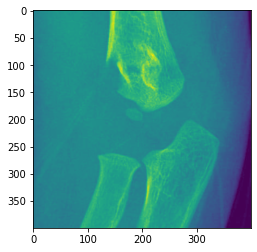

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


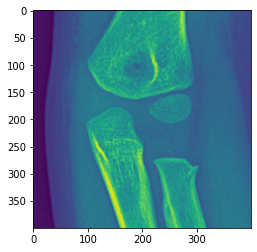

torch.Size([25, 1, 400, 400])
Label = 1 : Fracture image


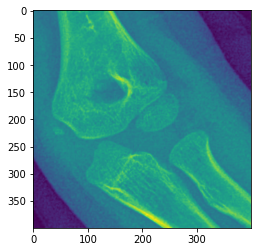

In [0]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in valid_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

In [0]:
# Build convolutional neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(51200,2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x


model = Net()

In [0]:
# Print the network you built
model.cuda()

Net(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
 

In [0]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [0]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
   # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        print('Valid_Prediction : {}'.format(pred))
        print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 0 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 48.333333333333336
Validation Accuracy : 51.68539325842697


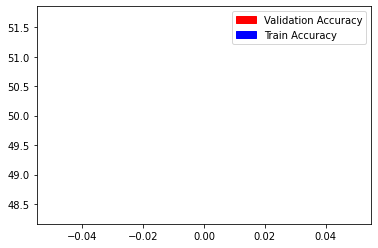

# Epoch : 1 /60
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 45.83333333333333
Validation Accuracy : 48.31460674157304


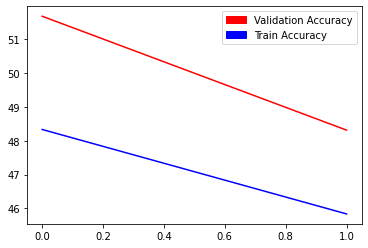

# Epoch : 2 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 45.83333333333333
Validation Accuracy : 51.68539325842697


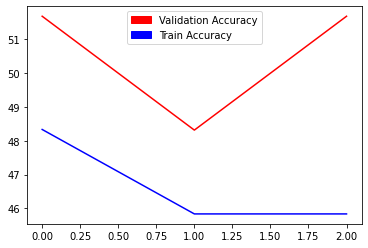

# Epoch : 3 /60
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 48.333333333333336
Validation Accuracy : 48.31460674157304


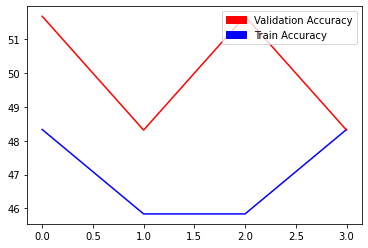

# Epoch : 4 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 47.5
Validation Accuracy : 51.68539325842697


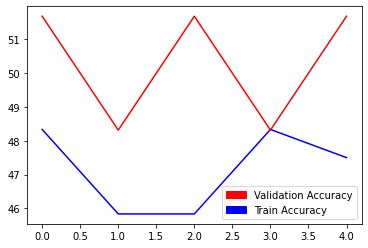

# Epoch : 5 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


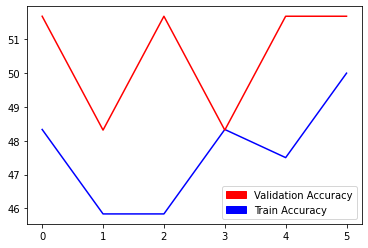

# Epoch : 6 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


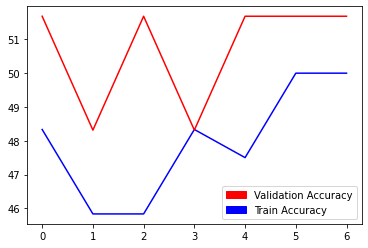

# Epoch : 7 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


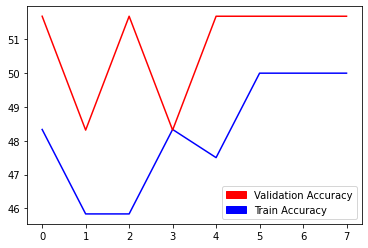

# Epoch : 8 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


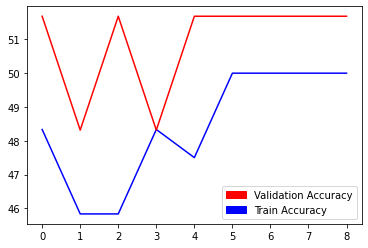

# Epoch : 9 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


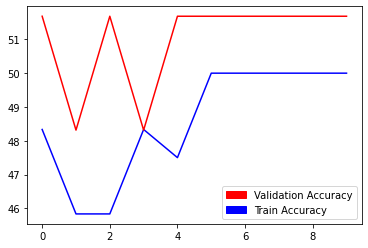

# Epoch : 10 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


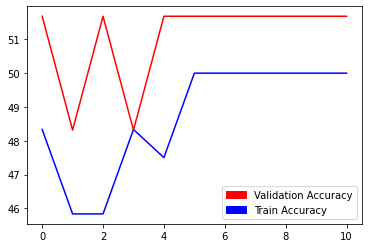

# Epoch : 11 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


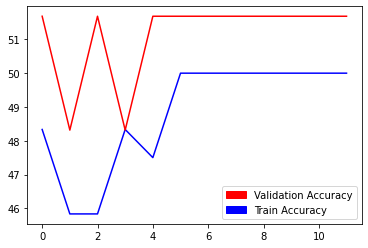

# Epoch : 12 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 51.68539325842697


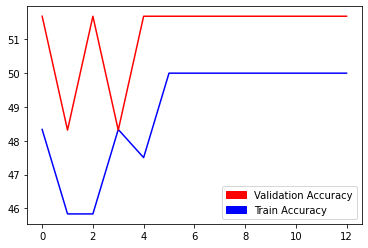

# Epoch : 13 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 51.66666666666667
Validation Accuracy : 52.80898876404494


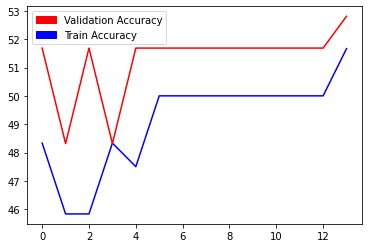

# Epoch : 14 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.0
Validation Accuracy : 55.0561797752809


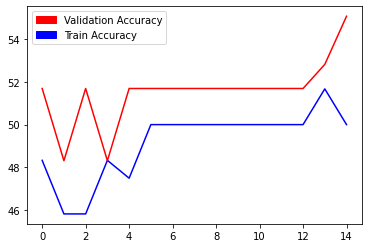

# Epoch : 15 /60
Valid_Prediction : [1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 62.5
Validation Accuracy : 60.67415730337079


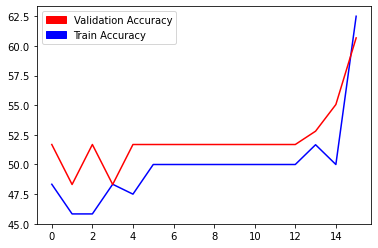

# Epoch : 16 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 53.75
Validation Accuracy : 60.67415730337079


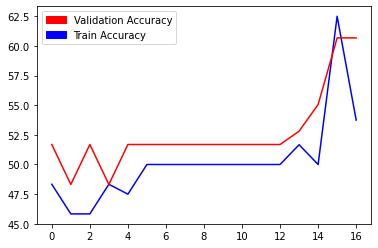

# Epoch : 17 /60
Valid_Prediction : [1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 63.33333333333333
Validation Accuracy : 58.42696629213483


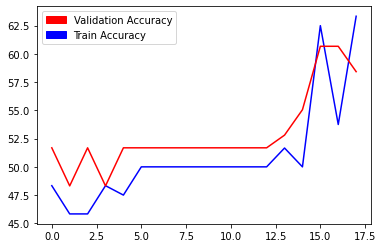

# Epoch : 18 /60
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 60.83333333333333
Validation Accuracy : 48.31460674157304


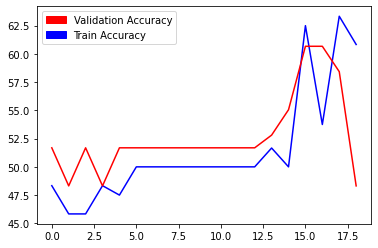

# Epoch : 19 /60
Valid_Prediction : [1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 56.25
Validation Accuracy : 60.67415730337079


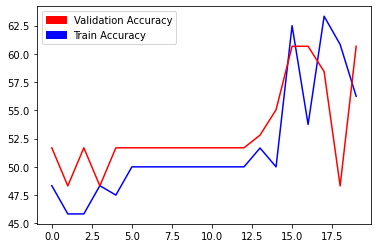

# Epoch : 20 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 62.5
Validation Accuracy : 55.0561797752809


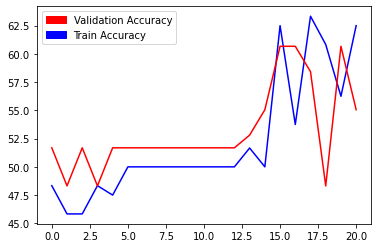

# Epoch : 21 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.25
Validation Accuracy : 53.93258426966292


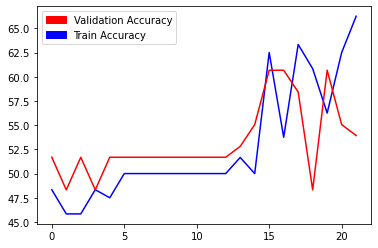

# Epoch : 22 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 61.25000000000001
Validation Accuracy : 55.0561797752809


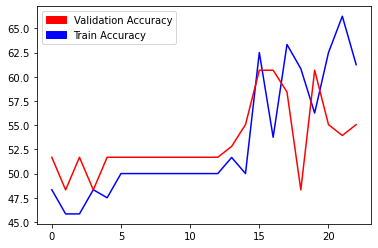

# Epoch : 23 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.08333333333333
Validation Accuracy : 53.93258426966292


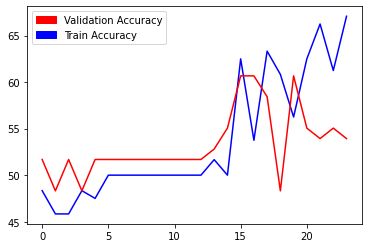

# Epoch : 24 /60
Valid_Prediction : [1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.91666666666667
Validation Accuracy : 57.30337078651685


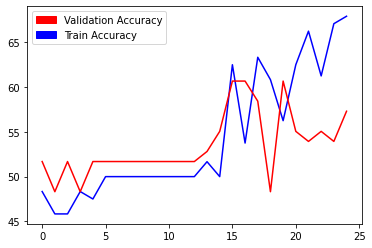

# Epoch : 25 /60
Valid_Prediction : [1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 65.41666666666667
Validation Accuracy : 61.79775280898876


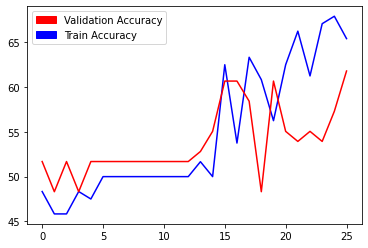

# Epoch : 26 /60
Valid_Prediction : [1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.5
Validation Accuracy : 57.30337078651685


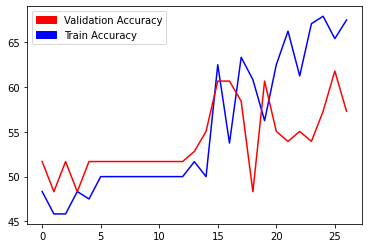

# Epoch : 27 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.25
Validation Accuracy : 57.30337078651685


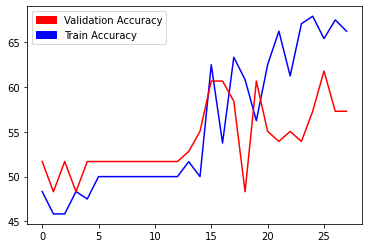

# Epoch : 28 /60
Valid_Prediction : [1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 65.0
Validation Accuracy : 60.67415730337079


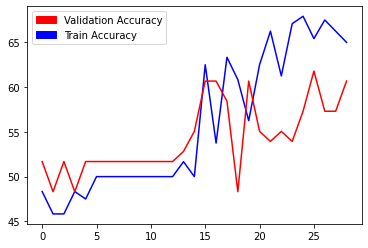

# Epoch : 29 /60
Valid_Prediction : [0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.66666666666666
Validation Accuracy : 53.93258426966292


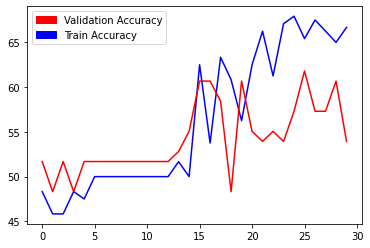

# Epoch : 30 /60
Valid_Prediction : [0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 69.16666666666667
Validation Accuracy : 52.80898876404494


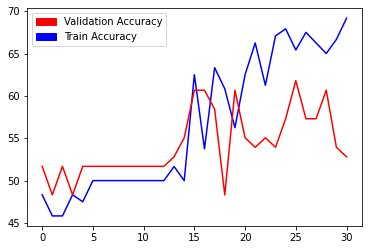

# Epoch : 31 /60
Valid_Prediction : [1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 69.16666666666667
Validation Accuracy : 59.55056179775281


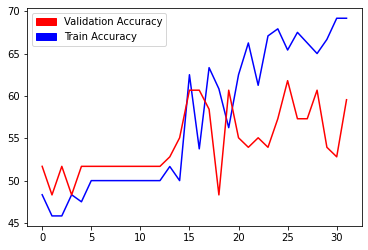

# Epoch : 32 /60
Valid_Prediction : [1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.91666666666667
Validation Accuracy : 60.67415730337079


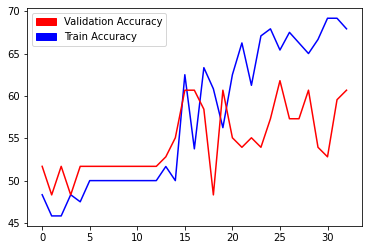

# Epoch : 33 /60
Valid_Prediction : [1 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 74.16666666666667
Validation Accuracy : 58.42696629213483


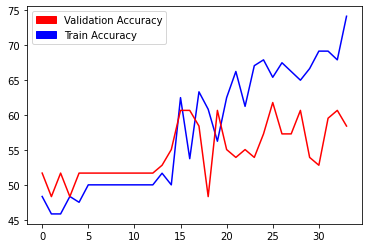

# Epoch : 34 /60
Valid_Prediction : [1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.08333333333333
Validation Accuracy : 53.93258426966292


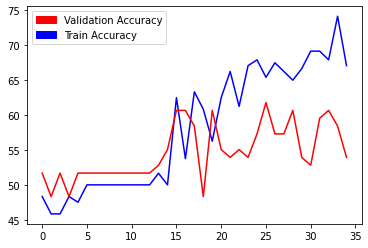

# Epoch : 35 /60
Valid_Prediction : [1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 72.91666666666666
Validation Accuracy : 57.30337078651685


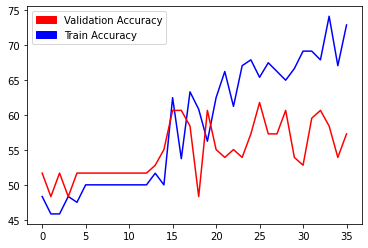

# Epoch : 36 /60
Valid_Prediction : [1 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 72.91666666666666
Validation Accuracy : 62.92134831460674


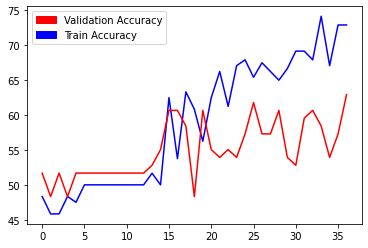

# Epoch : 37 /60
Valid_Prediction : [1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 75.41666666666667
Validation Accuracy : 58.42696629213483


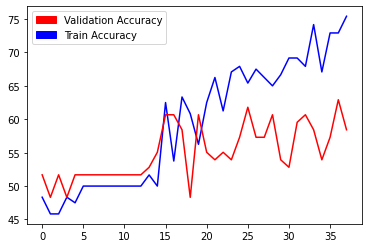

# Epoch : 38 /60
Valid_Prediction : [1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 74.16666666666667
Validation Accuracy : 62.92134831460674


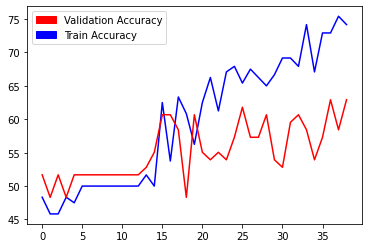

# Epoch : 39 /60
Valid_Prediction : [1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 72.91666666666666
Validation Accuracy : 60.67415730337079


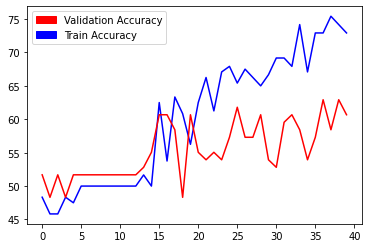

# Epoch : 40 /60
Valid_Prediction : [1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 72.91666666666666
Validation Accuracy : 56.17977528089888


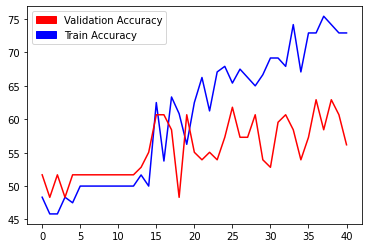

# Epoch : 41 /60
Valid_Prediction : [1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 71.66666666666667
Validation Accuracy : 64.04494382022472


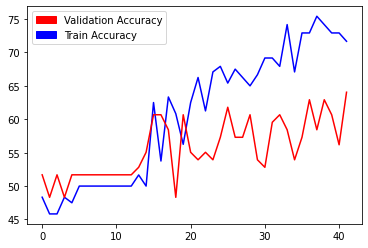

# Epoch : 42 /60
Valid_Prediction : [1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 73.33333333333333
Validation Accuracy : 61.79775280898876


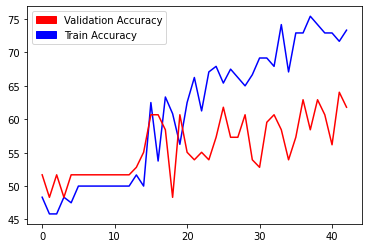

# Epoch : 43 /60
Valid_Prediction : [1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 72.91666666666666
Validation Accuracy : 60.67415730337079


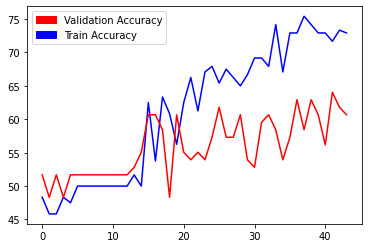

# Epoch : 44 /60
Valid_Prediction : [1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 75.83333333333333
Validation Accuracy : 62.92134831460674


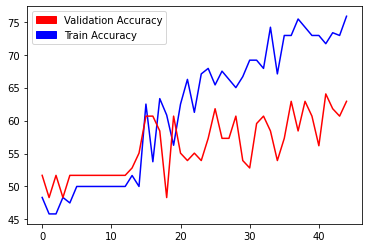

# Epoch : 45 /60
Valid_Prediction : [1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 74.58333333333333
Validation Accuracy : 62.92134831460674


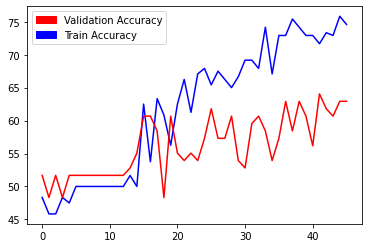

# Epoch : 46 /60
Valid_Prediction : [1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 75.83333333333333
Validation Accuracy : 62.92134831460674


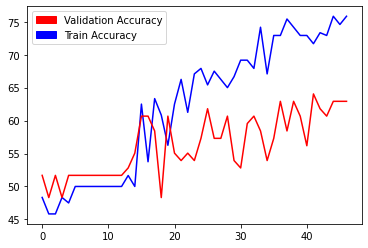

# Epoch : 47 /60
Valid_Prediction : [1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 74.58333333333333
Validation Accuracy : 61.79775280898876


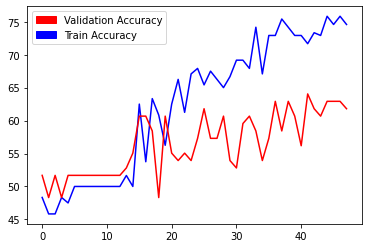

# Epoch : 48 /60
Valid_Prediction : [1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 78.75
Validation Accuracy : 64.04494382022472


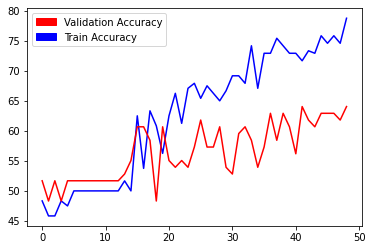

# Epoch : 49 /60
Valid_Prediction : [1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 77.91666666666667
Validation Accuracy : 66.29213483146067


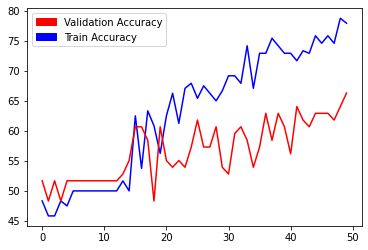

# Epoch : 50 /60
Valid_Prediction : [1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 75.41666666666667
Validation Accuracy : 59.55056179775281


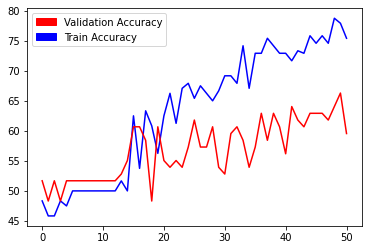

# Epoch : 51 /60
Valid_Prediction : [1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 75.83333333333333
Validation Accuracy : 64.04494382022472


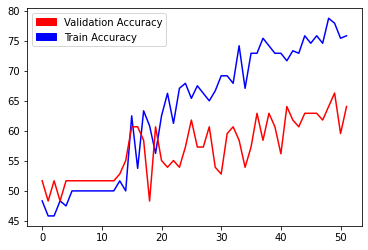

# Epoch : 52 /60
Valid_Prediction : [1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 76.66666666666667
Validation Accuracy : 60.67415730337079


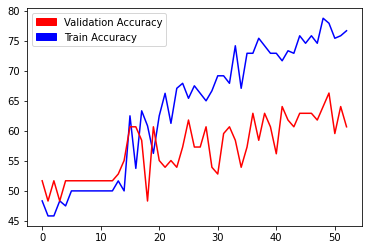

# Epoch : 53 /60
Valid_Prediction : [1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 75.41666666666667
Validation Accuracy : 61.79775280898876


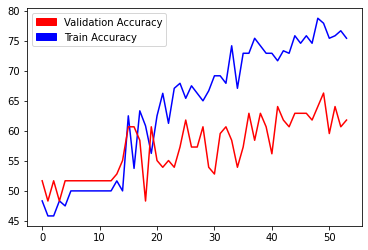

# Epoch : 54 /60
Valid_Prediction : [1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 78.75
Validation Accuracy : 64.04494382022472


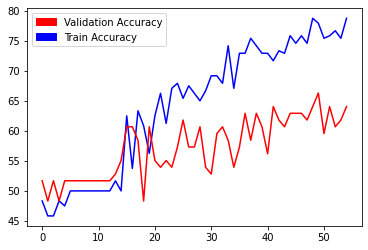

# Epoch : 55 /60
Valid_Prediction : [1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 79.16666666666666
Validation Accuracy : 66.29213483146067


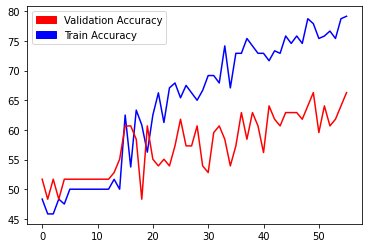

# Epoch : 56 /60
Valid_Prediction : [1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 74.58333333333333
Validation Accuracy : 61.79775280898876


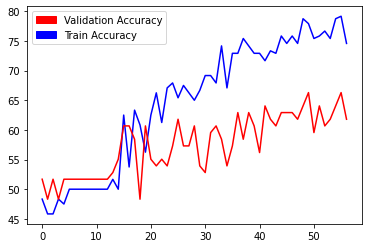

# Epoch : 57 /60
Valid_Prediction : [1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 77.91666666666667
Validation Accuracy : 59.55056179775281


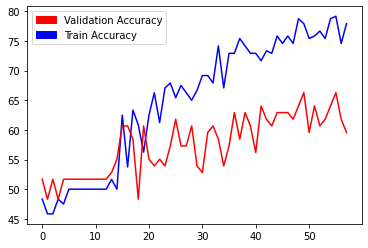

# Epoch : 58 /60
Valid_Prediction : [1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 77.91666666666667
Validation Accuracy : 65.1685393258427


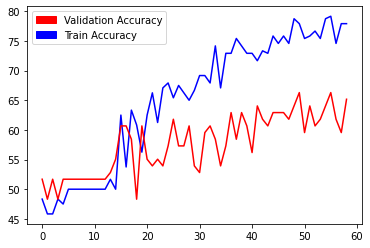

# Epoch : 59 /60
Valid_Prediction : [1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 78.33333333333333
Validation Accuracy : 60.67415730337079


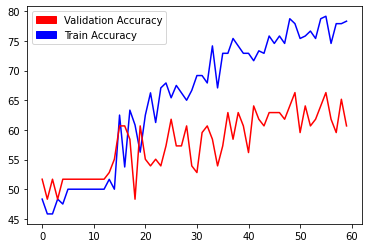

In [0]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(60):
    print('# Epoch : {} /60'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [0]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/My Drive/PatternProject/Model_FirstName_IDnumber')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
